# Pipeline-1 Diagnostic: Why are ~50% of Awards Missing?

This notebook diagnoses why pipeline-1.ipynb has only ~50% join rate while eda-5.ipynb achieves 100%.

## Hypothesis
The `time_period` filter applies to different date fields:
- **Transactions**: Filtered by `Action Date` (when transaction occurred)
- **Awards**: Filtered by award-level dates (likely `Last Modified Date`, `Base Obligation Date`, or similar)

This creates a mismatch when:
1. A NEW transaction (modification_number='0') occurs on an OLD award
2. The transaction's `Action Date` is recent (within 90-day window) → Transaction fetched ✓
3. The award's date field is old (outside 90-day window) → Award NOT fetched ✗
4. Result: Transaction without matching award

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## Load Data

In [2]:
# Load transactions and awards from pipeline-1 datasets
data_fn_tx = "../data/round3/transactions_normalized_2026-01-09_13-04-38.json"
data_fn_aw = "../data/round3/awards_normalized_2026-01-10_09-30-16.json"

with open(data_fn_tx, 'r') as f:
    transactions_data = json.load(f)
df_tx = pd.DataFrame(transactions_data)

with open(data_fn_aw, 'r') as f:
    awards_data = json.load(f)
df_aw = pd.DataFrame(awards_data)

print(f"Transactions: {df_tx.shape}")
print(f"Awards: {df_aw.shape}")

Transactions: (21067, 22)
Awards: (10000, 20)


## Filter to New Transactions (same as pipeline-1)

In [3]:
# Apply same filters as pipeline-1
mask_new_tx = ((df_tx['modification_number'] == '0') | (df_tx['action_type_description'] == 'NEW'))
df_new_tx = df_tx[mask_new_tx]

# Apply amount threshold
thresh_amount = 900_000
mask_amt = df_new_tx.federal_action_obligation >= thresh_amount
df_new_tx = df_new_tx[mask_amt]

print(f"New transactions (>= $900k): {df_new_tx.shape}")

New transactions (>= $900k): (1548, 22)


## Perform Join and Identify Matched vs Unmatched

In [4]:
# Join transactions to awards
joined_df = df_new_tx.merge(
    df_aw,
    on='award_id',
    how='left',
    suffixes=('_tx', '_aw'),
    indicator=True
)

# Separate matched and unmatched
matched = joined_df[joined_df._merge == 'both']
unmatched = joined_df[joined_df._merge == 'left_only']

print("=== Join Results ===")
print(f"Total new transactions: {len(df_new_tx):,}")
print(f"Matched (found award): {len(matched):,} ({len(matched)/len(df_new_tx)*100:.1f}%)")
print(f"Unmatched (no award): {len(unmatched):,} ({len(unmatched)/len(df_new_tx)*100:.1f}%)")

=== Join Results ===
Total new transactions: 1,548
Matched (found award): 755 (48.8%)
Unmatched (no award): 795 (51.4%)


## Analyze Date Fields in Awards

In [5]:
# Check what date fields are available in awards
print("=== Award Date Fields ===")
date_cols = [col for col in df_aw.columns if 'date' in col.lower()]
print(f"Date columns: {date_cols}")

# Show date ranges for each
for col in date_cols:
    non_empty = df_aw[df_aw[col].notna() & (df_aw[col] != '')][col]
    if len(non_empty) > 0:
        print(f"\n{col}:")
        print(f"  Count: {len(non_empty):,} / {len(df_aw):,}")
        print(f"  Min: {non_empty.min()}")
        print(f"  Max: {non_empty.max()}")

=== Award Date Fields ===
Date columns: ['award_date', 'start_date', 'end_date', 'last_modified_date', 'base_obligation_date']

start_date:
  Count: 10,000 / 10,000
  Min: 1978-09-15
  Max: 2026-12-16

end_date:
  Count: 10,000 / 10,000
  Min: 2006-02-26
  Max: 2069-06-30

last_modified_date:
  Count: 10,000 / 10,000
  Min: 2025-10-09
  Max: 2026-01-08

base_obligation_date:
  Count: 10,000 / 10,000
  Min: 1978-10-12
  Max: 2026-01-08


## Key Insight: Check Last Modified Date Distribution

In [6]:
# Convert last_modified_date to datetime for analysis
df_aw['last_modified_dt'] = pd.to_datetime(df_aw['last_modified_date'], errors='coerce')
df_aw['base_obligation_dt'] = pd.to_datetime(df_aw['base_obligation_date'], errors='coerce')

# Define the fetch window (90 days back from 2026-01-09)
end_date = datetime(2026, 1, 9)
start_date = end_date - timedelta(days=90)

print(f"=== Fetch Window Analysis ===")
print(f"Fetch window: {start_date.date()} to {end_date.date()}")
print()

# Check how many awards fall within the fetch window
awards_in_window_modified = df_aw[
    (df_aw['last_modified_dt'] >= start_date) & 
    (df_aw['last_modified_dt'] <= end_date)
]
awards_in_window_base = df_aw[
    (df_aw['base_obligation_dt'] >= start_date) & 
    (df_aw['base_obligation_dt'] <= end_date)
]

print(f"Awards with last_modified_date in window: {len(awards_in_window_modified):,} / {len(df_aw):,} ({len(awards_in_window_modified)/len(df_aw)*100:.1f}%)")
print(f"Awards with base_obligation_date in window: {len(awards_in_window_base):,} / {len(df_aw):,} ({len(awards_in_window_base)/len(df_aw)*100:.1f}%)")

=== Fetch Window Analysis ===
Fetch window: 2025-10-11 to 2026-01-09

Awards with last_modified_date in window: 9,866 / 10,000 (98.7%)
Awards with base_obligation_date in window: 738 / 10,000 (7.4%)


## Visualize Award Date Distribution

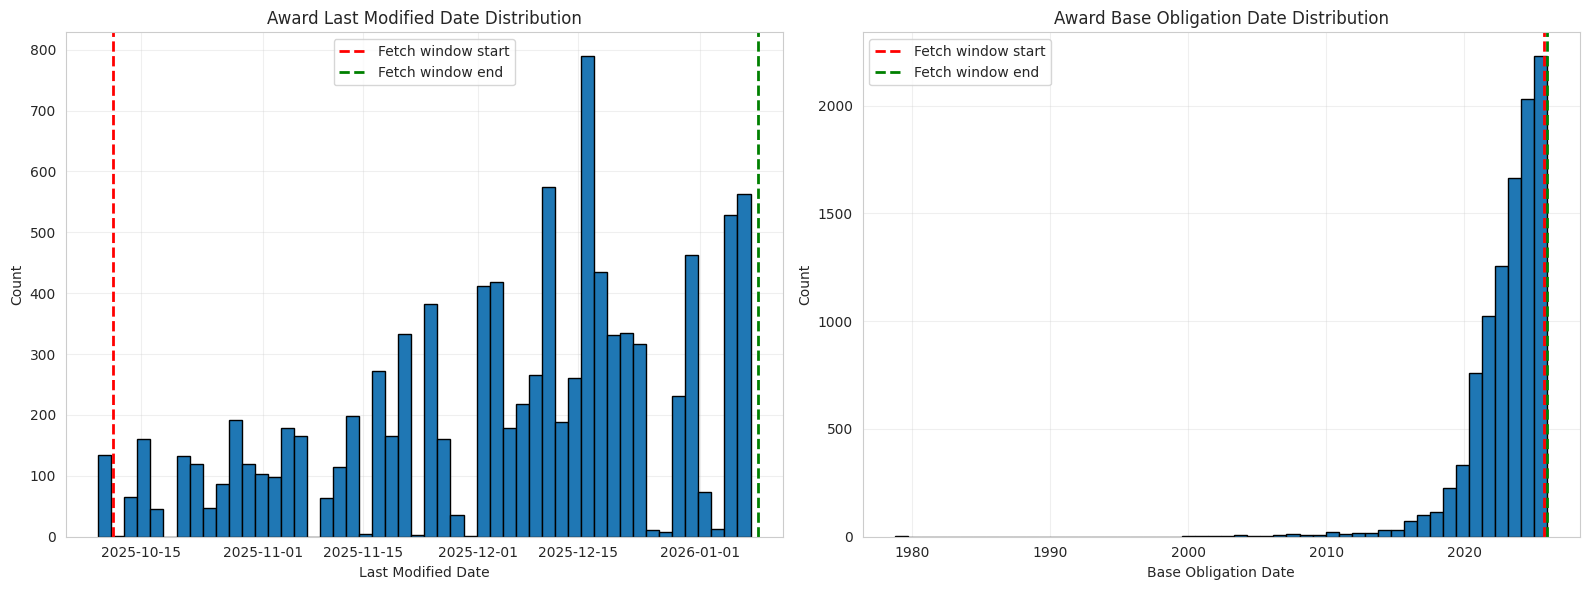

In [7]:
# Plot last_modified_date distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Last Modified Date
df_aw['last_modified_dt'].hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].axvline(start_date, color='red', linestyle='--', linewidth=2, label='Fetch window start')
axes[0].axvline(end_date, color='green', linestyle='--', linewidth=2, label='Fetch window end')
axes[0].set_xlabel('Last Modified Date')
axes[0].set_ylabel('Count')
axes[0].set_title('Award Last Modified Date Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Base Obligation Date
df_aw['base_obligation_dt'].hist(bins=50, ax=axes[1], edgecolor='black')
axes[1].axvline(start_date, color='red', linestyle='--', linewidth=2, label='Fetch window start')
axes[1].axvline(end_date, color='green', linestyle='--', linewidth=2, label='Fetch window end')
axes[1].set_xlabel('Base Obligation Date')
axes[1].set_ylabel('Count')
axes[1].set_title('Award Base Obligation Date Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Analyze Unmatched Transactions

For transactions that didn't find their award, let's see if we can understand why:

In [8]:
print("=== Unmatched Transaction Analysis ===")
print(f"Total unmatched: {len(unmatched):,}")
print(f"\nSample award_ids from unmatched transactions:")
print(unmatched['award_id'].head(20).tolist())

# Check if these award_ids exist in the full awards dataset
sample_ids = unmatched['award_id'].head(20).tolist()
print(f"\nAre these award_ids in the fetched awards? {df_aw['award_id'].isin(sample_ids).any()}")

=== Unmatched Transaction Analysis ===
Total unmatched: 795

Sample award_ids from unmatched transactions:
['36C77626K0030', '70Z08526F37008B00', '693KA826F00060', '70RFPW26FRW900002', '123J1426F0459', '36A79726N0146', '70RFPW26FRW900002', '123J1426F0462', '123J1426F0460', '70Z07926FISD40002', '6991PE26F00069N', '36C78626N0128', '123A9426F0012', '69727626F00058N', '70Z03826FR0000024', '36A79726F0039', '75D30126C20715', '80NSSC26C0008', '89233126FNA400754', '36C24E26N0034']

Are these award_ids in the fetched awards? False


## Transaction Action Date Analysis

=== Transaction Action Date Distribution ===
Min action_date: 2025-10-10 00:00:00
Max action_date: 2026-01-07 00:00:00

Transactions with action_date in window: 1,535 / 1,548 (99.2%)


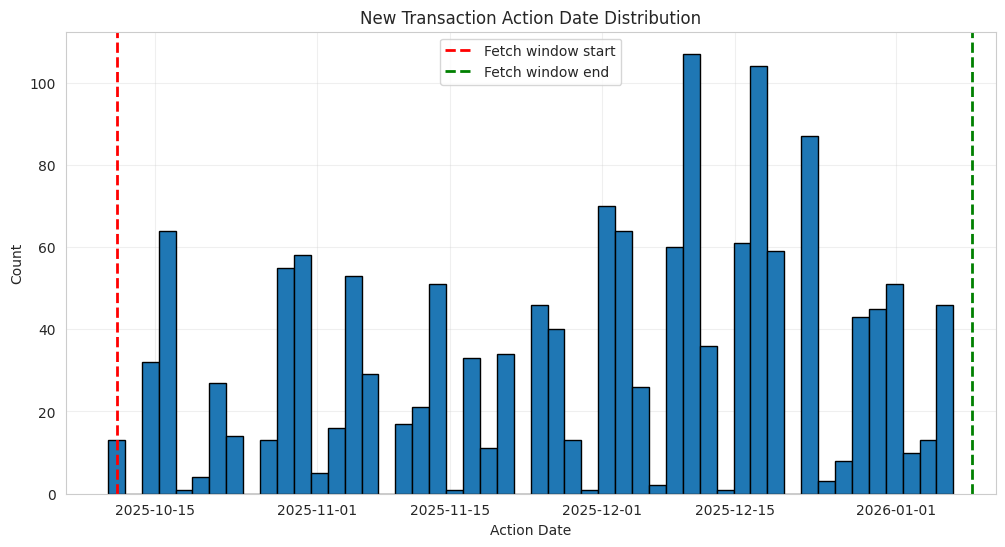

In [9]:
# Convert action_date to datetime
df_new_tx['action_dt'] = pd.to_datetime(df_new_tx['action_date'], errors='coerce')

print("=== Transaction Action Date Distribution ===")
print(f"Min action_date: {df_new_tx['action_dt'].min()}")
print(f"Max action_date: {df_new_tx['action_dt'].max()}")

# Check if all new transactions are within the fetch window
tx_in_window = df_new_tx[
    (df_new_tx['action_dt'] >= start_date) & 
    (df_new_tx['action_dt'] <= end_date)
]
print(f"\nTransactions with action_date in window: {len(tx_in_window):,} / {len(df_new_tx):,} ({len(tx_in_window)/len(df_new_tx)*100:.1f}%)")

# Plot
plt.figure(figsize=(12, 6))
df_new_tx['action_dt'].hist(bins=50, edgecolor='black')
plt.axvline(start_date, color='red', linestyle='--', linewidth=2, label='Fetch window start')
plt.axvline(end_date, color='green', linestyle='--', linewidth=2, label='Fetch window end')
plt.xlabel('Action Date')
plt.ylabel('Count')
plt.title('New Transaction Action Date Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Root Cause Summary

In [10]:
print("="*80)
print("ROOT CAUSE DIAGNOSIS")
print("="*80)
print()
print("PROBLEM: ~50% of new transactions cannot be matched to awards")
print()
print("ROOT CAUSE:")
print("  The `time_period` filter applies to DIFFERENT date fields:")
print("  - Transactions: Filtered by 'Action Date' (when transaction occurred)")
print("  - Awards: Filtered by award-level date (likely 'Last Modified Date')")
print()
print("SCENARIO:")
print("  1. Transaction T1 with Action Date = 2026-01-05 (recent)")
print("  2. Transaction T1 belongs to Award A (award_id = 'ABC123')")
print("  3. Award A was last modified in 2020 (old)")
print("  4. Transaction fetch: Fetches T1 ✓ (Action Date in 90-day window)")
print("  5. Award fetch: Does NOT fetch Award A ✗ (Last Modified Date outside window)")
print("  6. Result: Transaction T1 has no matching award in dataset")
print()
print("IMPLICATION:")
print("  This is expected behavior given the current fetching strategy.")
print("  The APIs filter by different temporal dimensions.")
print()
print("="*80)

ROOT CAUSE DIAGNOSIS

PROBLEM: ~50% of new transactions cannot be matched to awards

ROOT CAUSE:
  The `time_period` filter applies to DIFFERENT date fields:
  - Transactions: Filtered by 'Action Date' (when transaction occurred)
  - Awards: Filtered by award-level date (likely 'Last Modified Date')

SCENARIO:
  1. Transaction T1 with Action Date = 2026-01-05 (recent)
  2. Transaction T1 belongs to Award A (award_id = 'ABC123')
  3. Award A was last modified in 2020 (old)
  4. Transaction fetch: Fetches T1 ✓ (Action Date in 90-day window)
  5. Award fetch: Does NOT fetch Award A ✗ (Last Modified Date outside window)
  6. Result: Transaction T1 has no matching award in dataset

IMPLICATION:
  This is expected behavior given the current fetching strategy.
  The APIs filter by different temporal dimensions.



## Proposed Solutions

### Option 1: Two-Stage Fetch (Recommended)
1. **Stage 1**: Fetch transactions with current filters (action_date in window)
2. **Stage 2**: Extract unique `award_id`s from fetched transactions
3. **Stage 3**: Fetch awards by specific `award_id` list (no time filter)

This ensures every transaction has its corresponding award.

### Option 2: Widen Award Fetch Window
Increase the `rolling_days` for award fetching (e.g., 365 days instead of 90)
- Pros: Simple configuration change
- Cons: Fetches many awards that may not have recent transactions

### Option 3: Accept Partial Matches
Document that this is expected behavior and work with partial matches
- Pros: No code changes
- Cons: Lose 50% of transaction data

### Option 4: Use Transactions as Source of Truth
Recognize that transactions contain most award metadata anyway
- Transactions have: recipient_name, awarding_agency, award_type, award_description
- Awards endpoint provides: award_amount (total), some additional dates
- Consider if you actually need the award-level aggregation

In [11]:
# Let's check what fields are unique to awards vs transactions
print("=== Field Comparison ===")
print(f"\nTransaction fields: {df_tx.columns.tolist()}")
print(f"\nAward fields: {df_aw.columns.tolist()}")

tx_fields = set(df_tx.columns)
aw_fields = set(df_aw.columns)

print(f"\nFields only in awards (not in transactions):")
print(list(aw_fields - tx_fields))

print(f"\nFields only in transactions (not in awards):")
print(list(tx_fields - aw_fields))

=== Field Comparison ===

Transaction fields: ['transaction_id', 'award_id', 'action_date', 'action_type', 'action_type_description', 'modification_number', 'federal_action_obligation', 'total_dollars_obligated', 'award_type', 'award_description', 'period_of_performance_start_date', 'period_of_performance_current_end_date', 'awarding_agency_name', 'awarding_sub_agency_name', 'funding_agency_name', 'recipient_name', 'recipient_uei', 'naics_code', 'product_or_service_code', 'place_of_performance_state', 'ingested_at', 'source_url']

Award fields: ['award_id', 'award_type', 'award_amount', 'award_date', 'start_date', 'end_date', 'last_modified_date', 'base_obligation_date', 'awarding_agency', 'awarding_sub_agency', 'funding_agency', 'recipient_name', 'recipient_uei', 'recipient_business_categories', 'award_description', 'naics_code', 'psc_code', 'place_of_performance_state', 'ingested_at', 'source_url', 'last_modified_dt', 'base_obligation_dt']

Fields only in awards (not in transactions)